## GovTech DSAID (TAP) Technical Assessment 

### <u> Section 2 (scenario 1) - Analysis of impact of Expressway proxmity on HDB Resale Flats</u>

<b>Scenario 1:</b> Some forum posters have complained that the value of their HDB flats suffer because they are near expressways, which are very noisy. Others say expressway proximity is good, due to the unblocked view (at least for higher floors). The Housing and Development Board has tasked your team to analyse whether there is merit to either view, based on transaction prices for resale HDB flats in recent years

#### Notebook Sections:
1. Data Preprocessing (HDB Data, National Map Line Data)
2. Finding nearest distance from HDBs to Expressway
3. Analysis of effect of Expressway proximity
4. Further study

<b><font color='red'>Updates (post-submission):</b>
- Updated to use recent data (till Aug 2023) - previously only used data up till Dec 2022
- Section on explainability of factors using SHAP
- Section on DiD modelling
   
    

In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from datetime import datetime
from statistics import mean,median,mode,stdev
import re
import json
import seaborn as sns

# Ignore warnings (for readability)
import warnings
warnings.filterwarnings("ignore")

## 1. Data Pre-processing
### 1.1 HDB Data <font color='red'>*do not run code in this section, APIs don't seem to be working as they used to. Please skip to section 1.1.3 and start running code from there

#### 1.1.1 Pulling Data from data.gov.sg APIs* 

It seems that the data.gov.sg APIs which worked in the past are now possibly rate limited. I've downloaded and processed the HDB dataset in the past, so will just use that directly instead - see section 1.1.3. (in the interest of time, given the multiple assignments).

- Nonethless, still including section 1.1 on pulling HDB data from data.gov.sg APIs and how the data was processed (e.g. accounting for inflation, feature engineering for resale price/sqm)

In [ ]:
def fetch_data(url):
    resp = requests.get(url)
    data = json.loads(resp.content)
    return data['result']['records']

datasets = ['2017_data','2015-16_data','2012-14_data','2000-12_data','1990-99_data']

urls = {
    datasets[0]: 'https://data.gov.sg/api/action/datastore_search?resource_id=f1765b54-a209-4718-8d38-a39237f502b3&limit=200000',
    datasets[1]: 'https://data.gov.sg/api/action/datastore_search?resource_id=1b702208-44bf-4829-b620-4615ee19b57c&limit=500000',
    datasets[2]: 'https://data.gov.sg/api/action/datastore_search?resource_id=83b2fc37-ce8c-4df4-968b-370fd818138b&limit=500000',
    datasets[3]: 'https://data.gov.sg/api/action/datastore_search?resource_id=8c00bf08-9124-479e-aeca-7cc411d884c4&limit=500000',
    datasets[4]: 'https://data.gov.sg/api/action/datastore_search?resource_id=adbbddd3-30e2-445f-a123-29bee150a6fe&limit=500000'
}

data_dict = {name: fetch_data(url) for name, url in urls.items()}

In [ ]:
# note we cannot assume the columns pulled from different APIs are the same - so we'll compare them first

s1 = set(data_dict['2017_data'][0].keys())
s2 = set(data_dict['2015-16_data'][0].keys())
s3 = set(data_dict['2012-14_data'][0].keys())
s4 = set(data_dict['2000-12_data'][0].keys())
s5 = set(data_dict['1990-99_data'][0].keys())

col = [s1,s2,s3,s4,s5]
for i in range(5):
    for j in range(5):
        if col[i] == col[j] and i<j:
            print('s'+str(i+1)+' and '+'s'+str(j+1)+' are equal')   
            
# observe that the 2015-16 and 2017 sets have the same columns, and 1990-2014 sets have the same columns. 
print(s1-s3,s3-s1) 

# observe that the 1990-2014 sets (s3, s4, s5) are missing a 'remaining_lease' column
def standardize_columns(hdb_dict):
    for i in range(len(hdb_dict)):
        hdb_dict[i]['remaining_lease'] = 'nil'

standardize_columns(data_dict['2012-14_data'])
standardize_columns(data_dict['2000-12_data'])
standardize_columns(data_dict['1990-99_data'])

In [ ]:
# convert to pandas dataframe
df = pd.DataFrame()
for i in datasets:
    df = pd.concat([df, pd.DataFrame.from_dict(data_dict[i])])
df.head()

#### 1.1.2 Data Cleaning and Feature Engineering

In [ ]:
# overview of the dataset
print(df.info())

# drop unnecessary columns
df = df.drop('_id',axis=1)

# convert data types
df["floor_area_sqm"] = df['floor_area_sqm'].astype('float')
df["resale_price"] = df['resale_price'].astype('float')
df['month'] = pd.to_datetime(df['month'])
df['lease_commence_date'] = pd.to_datetime(df['lease_commence_date'])

In [ ]:
# FEATURE ENGINEERING - CORRECT FOR INFLATION:
# 1. Get inflation data
df_inflation = pd.read_html("https://www.rateinflation.com/consumer-price-index/singapore-historical-cpi/")
df_inflation[0].head()
df_inflation_normalized = float(df_inflation[0][df_inflation[0]['Year'] == 2022]['nov'])/df_inflation[0]
df_inflation_normalized = df_inflation_normalized.drop('Year',axis=1)
df_inflation_normalized.index = df_inflation[0]['Year']
df_inflation_normalized.loc[2022]['dec'] = 1
df_inflation_normalized.columns = [1,2,3,4,5,6,7,8,9,10,11,12,'Annual']

# 2. Append a column for inflation
df['inflation'] = 1.0
yr = 0
mth = 0
for i in range(0,len(df)):
    yr = df['month'].dt.year.iloc[0]
    mth = df['month'][i].dt.month.iloc[0]
    df['inflation'][i] = df_inflation_normalized.loc[yr][mth]
    
# 3. Multiply by inflation; and can drop column if necessary. (this step can also be decluttered lol)
df['resale_price_with_inf'] = df['resale_price'] * df['inflation']
df = df.drop(['resale_price','inflation'],axis=1)

# FEATURE ENGINEERING - PRICE/SQM
df_hdb_price['resale_price/sqm'] = df_hdb_price['resale_price_with_inf']/df_hdb_price['floor_area_sqm']

#### 1.1.3 Geocoding (because of the length of API calls - takes eons to run)
- See 'Geocoding APIs (HDB Resale Dataset)'
- Showing the o/p from Geocoding below

In [12]:
df_hdb = pd.read_csv("hdb_prices_geocoded.csv", index_col = 0)
df_hdb.head()

,latitude,longitude,address,town,flat_type,flat_model,floor_area_sqm,month,remaining_lease,lease_commence_date,storey_range,resale_price_with_inf,resale_price/sqm
0,1.377259,103.748292,818B CHOA CHU KANG AVE 1,CHOA CHU KANG,4 ROOM,Model A,92.0,2022-12-01,93.833333,2017,19 TO 21,580000.000000,6304.347826
1,1.377259,103.748292,818B CHOA CHU KANG AVE 1,CHOA CHU KANG,4 ROOM,Model A,92.0,2022-12-01,93.916667,2017,01 TO 03,508000.000000,5521.739130
2,1.377259,103.748292,818B CHOA CHU KANG AVE 1,CHOA CHU KANG,4 ROOM,Model A,92.0,2022-11-01,93.916667,2017,10 TO 12,568000.000000,6173.913043
3,1.377259,103.748292,818B CHOA CHU KANG AVE 1,CHOA CHU KANG,4 ROOM,Model A,92.0,2022-09-01,94.083333,2017,04 TO 06,532978.094781,5793.240161
4,1.377259,103.748292,818B CHOA CHU KANG AVE 1,CHOA CHU KANG,4 ROOM,Model A,92.0,2022-07-01,94.250000,2017,04 TO 06,519948.270793,5651.611639


### 1.2 Expressway Data Preprocessing - National Map Line Dataset 

In [21]:
import geopandas as gpd
from bs4 import BeautifulSoup

# Read dataset
df_map = gpd.read_file("NationalMapLineKML.geojson")
df_map.head()

,Name,Description,geometry
0,kml_1,<center><table><tr><th colspan='2' align='cent...,"LINESTRING Z (103.85833 1.35595 0.00000, 103.8..."
1,kml_2,<center><table><tr><th colspan='2' align='cent...,"LINESTRING Z (103.85759 1.35611 0.00000, 103.8..."
2,kml_3,<center><table><tr><th colspan='2' align='cent...,"LINESTRING Z (103.86042 1.36817 0.00000, 103.8..."
3,kml_4,<center><table><tr><th colspan='2' align='cent...,"LINESTRING Z (103.85978 1.37228 0.00000, 103.8..."
4,kml_5,<center><table><tr><th colspan='2' align='cent...,"LINESTRING Z (103.85937 1.36913 0.00000, 103.8..."


#### Parse 'Description' Columns (same as Section 1 Qn 3)

In [97]:
df_map['Description'][0]

'<center><table><tr><th colspan=\'2\' align=\'center\'><em>Attributes</em></th></tr><tr bgcolor="#E3E3F3"> <th>NAME</th> <td>CENTRAL EXPRESSWAY</td> </tr><tr bgcolor=""> <th>FOLDERPATH</th> <td>Layers/Expressway_Sliproad</td> </tr><tr bgcolor="#E3E3F3"> <th>SYMBOLID</th> <td>2</td> </tr><tr bgcolor=""> <th>INC_CRC</th> <td>0C08DFFA475DDCCD</td> </tr><tr bgcolor="#E3E3F3"> <th>FMEL_UPD_D</th> <td>20191008154530</td> </tr></table></center>'

In [15]:
# Create a function to parse html strings 
def parse_html(html_string):
    # Parse the HTML using BeautifulSoup
    soup = BeautifulSoup(html_string, 'html.parser')

    # Extract the table rows
    rows = soup.find_all('tr')

    # Initialize empty lists to store the attributes and values
    attributes = []
    values = []

    # Iterate through the rows and extract the attribute and value from each row
    for row in rows:
        cols = row.find_all(['th', 'td'])
        if len(cols) == 2:
            attribute = cols[0].text.strip()
            value = cols[1].text.strip()
            attributes.append(attribute)
            values.append(value)

    # Create a DataFrame from the parsed data
    df = pd.DataFrame({'Attributes': attributes, 'Values': values}).set_index('Attributes').transpose()

    return(df)

In [16]:
df_parsed = pd.DataFrame()
for description in df_map['Description']:
    df_parsed = df_parsed.append(parse_html(description))
    
df_parsed.head()

Attributes,NAME,FOLDERPATH,SYMBOLID,INC_CRC,FMEL_UPD_D
Values,CENTRAL EXPRESSWAY,Layers/Expressway_Sliproad,2,0C08DFFA475DDCCD,20191008154530
Values,CENTRAL EXPRESSWAY,Layers/Expressway_Sliproad,2,48A90A617CC124B8,20191008154530
Values,CENTRAL EXPRESSWAY,Layers/Expressway_Sliproad,2,051AA478B6209021,20191008154530
Values,CENTRAL EXPRESSWAY,Layers/Expressway_Sliproad,2,1C51FD53E1662A6B,20191008154530
Values,CENTRAL EXPRESSWAY,Layers/Expressway_Sliproad,2,44D0FFDF1EF47027,20191008154530


In [100]:
# concat dataframes
df_map = pd.concat([df_map,df_parsed.reset_index().drop(columns = 'index', axis=1)],axis=1) 
df_map = df_map.drop(columns = ['Description'], axis =1)

# drop non-expressways (should have done this earlier)
df_map = df_map[df_map['NAME'].str.contains('Expressway|East Coast Parkway', case=False)]

In [ ]:
# for exporting the relevant expressways to geoJSON files (for Tableau)
dfmap1 = df_map.copy()

for i in df_map1['NAME'].unique():
    df_exp = df_map[df_map['Description'].str.contains(i, case=False)]
    df_exp.to_file(i+".geojson", driver = 'GeoJSON')

# 2. Find Nearest Distance of HDB Flats to Expressway

In [66]:
# Drop duplicate hdb address (else will be needlessly slow)
df_dedup = df_hdb.drop_duplicates('address')

In [96]:
# Remove rows with no lat/long (this is abt 1.2% of all the addresses (refer to geocoding notebook); quite insignificant)
df_dedup = df_dedup[(df_dedup['latitude'] != 'No results') & (df_dedup['longitude'] != 'No results')]

In [100]:
# Convert latitude and longitude to Point objects
from shapely.geometry import Point
df_dedup['geometry'] = df_dedup.apply(lambda row: Point(float(row['longitude']), float(row['latitude'])), axis=1)

# Convert the DataFrame to a GeoDataFrame
gdf_points_clean = gpd.GeoDataFrame(df_dedup, geometry='geometry')

gdf_points_clean.head(1)

,latitude,longitude,address,town,flat_type,flat_model,floor_area_sqm,month,remaining_lease,lease_commence_date,storey_range,resale_price_with_inf,resale_price/sqm,geometry
0,1.377259,103.748292,818B CHOA CHU KANG AVE 1,CHOA CHU KANG,4 ROOM,Model A,92.0,2022-12-01,93.833333,2017,19 TO 21,580000.0,6304.347826,POINT (103.74829 1.37726)


In [126]:
from shapely.ops import nearest_points
from tqdm import tqdm

# Convert back to a GeoDataFrame
gdf_lines = gpd.GeoDataFrame(df_map, geometry='geometry')

# Initialize columns for the nearest line and the distance
df_dedup['nearest_line'] = None
df_dedup['distance'] = None

# Iterate over all points
for idx_point, row_point in tqdm(df_dedup.iterrows(), total=df_dedup.shape[0]):
    min_dist = float('inf')
    nearest_line = None

    # Iterate over all lines
    for idx_line, row_line in gdf_lines.iterrows():
        # Calculate the distance from the point to the line
        dist = row_point.geometry.distance(row_line.geometry)

        # Update the minimum distance and the nearest line
        if dist < min_dist:
            min_dist = dist
            nearest_line = row_line.NAME

    # Update the 'nearest_line' and 'distance' columns
    df_dedup.loc[idx_point, 'nearest_line'] = nearest_line
    df_dedup.loc[idx_point, 'distance'] = min_dist

100%|██████████| 9556/9556 [22:51<00:00,  6.97it/s]


In [15]:
# Conversion factor from degrees to kilometers
degrees_to_km = 111.32
df_dedup['distance (km)'] = df_dedup['distance'] * degrees_to_km

# Merge back with original hdb dataframe
df_hdb_ex = df_hdb.merge(df_dedup[['address','nearest_line','distance (km)']], on="address", how='inner')
print(df_hdb.shape)
df_hdb_ex.head(1)

(889344, 13)


,latitude,longitude,address,town,flat_type,flat_model,floor_area_sqm,month,remaining_lease,lease_commence_date,storey_range,resale_price_with_inf,resale_price/sqm,nearest_line,distance (km)
0,1.377259,103.748292,818B CHOA CHU KANG AVE 1,CHOA CHU KANG,4 ROOM,Model A,92.0,2022-12-01,93.833333,2017,19 TO 21,580000.0,6304.347826,KRANJI EXPRESSWAY,136.20672


# 3. Analysis - Effect of distance from expressway

Given the long processing time up to here, have downloaded the csv file from the above to be read directly

In [39]:
# Read dataframe directly by running this if necessary!
df_hdb_ex = pd.read_csv("hdb_expressway.csv")

In [40]:
df_hdb_ex['resale_date'] = pd.to_datetime(df_hdb_ex['month'])
df_hdb_ex['distance'] = pd.to_numeric(df_hdb_ex['distance (km)'])
df_hdb_ex = df_hdb_ex.drop(columns = ['month','distance (km)'], axis=1)

Since the prompt states 'recent time', let's just take the past 5 years

In [41]:
df = df_hdb_ex[df_hdb_ex['resale_date'] > datetime(2018,1,1)]

In [42]:
max(df.resale_date) # quite limited; might want to refresh with more recent data 

Timestamp('2022-12-01 00:00:00')

In [43]:
df

,latitude,longitude,address,town,flat_type,flat_model,floor_area_sqm,remaining_lease,lease_commence_date,storey_range,resale_price_with_inf,resale_price/sqm,nearest_line,resale_date,distance
0,1.377259,103.748292,818B CHOA CHU KANG AVE 1,CHOA CHU KANG,4 ROOM,Model A,92.0,93.833333,2017,19 TO 21,5.800000e+05,6304.347826,KRANJI EXPRESSWAY,2022-12-01,1.223560
1,1.377259,103.748292,818B CHOA CHU KANG AVE 1,CHOA CHU KANG,4 ROOM,Model A,92.0,93.916667,2017,01 TO 03,5.080000e+05,5521.739130,KRANJI EXPRESSWAY,2022-12-01,1.223560
2,1.377259,103.748292,818B CHOA CHU KANG AVE 1,CHOA CHU KANG,4 ROOM,Model A,92.0,93.916667,2017,10 TO 12,5.680000e+05,6173.913043,KRANJI EXPRESSWAY,2022-11-01,1.223560
3,1.377259,103.748292,818B CHOA CHU KANG AVE 1,CHOA CHU KANG,4 ROOM,Model A,92.0,94.083333,2017,04 TO 06,5.329781e+05,5793.240161,KRANJI EXPRESSWAY,2022-09-01,1.223560
4,1.377259,103.748292,818B CHOA CHU KANG AVE 1,CHOA CHU KANG,4 ROOM,Model A,92.0,94.250000,2017,04 TO 06,5.199483e+05,5651.611639,KRANJI EXPRESSWAY,2022-07-01,1.223560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
867396,1.285671,103.830832,26 TIONG BAHRU RD,BUKIT MERAH,3 ROOM,Standard,88.0,53.833333,1973,01 TO 03,6.648668e+05,7555.304159,CENTRAL EXPRESSWAY,2018-03-01,0.446562
867410,1.379099,103.938291,651 PASIR RIS DR 10,PASIR RIS,EXECUTIVE,Apartment,148.0,76.583333,1995,04 TO 06,6.133350e+05,4144.155688,TAMPINES EXPRESSWAY,2018-02-01,0.627137
867455,1.327746,103.855881,52 JLN BAHAGIA,KALLANG/WHAMPOA,3 ROOM,Terrace,141.0,53.416667,1972,01 TO 03,1.003639e+06,7118.008223,PAN ISLAND EXPRESSWAY,2018-02-01,0.110665
867470,1.277277,103.831093,147 SILAT AVE,BUKIT MERAH,3 ROOM,New Generation,67.0,63.500000,1982,01 TO 03,3.401222e+05,5076.450143,CENTRAL EXPRESSWAY,2018-02-01,0.221342


#### 3.1 Basic EDA

-0.13873908322059836


Text(0.5, 1.0, 'Resale price per sqm against Distance to nearest Expressway (correlation = -0.14)')

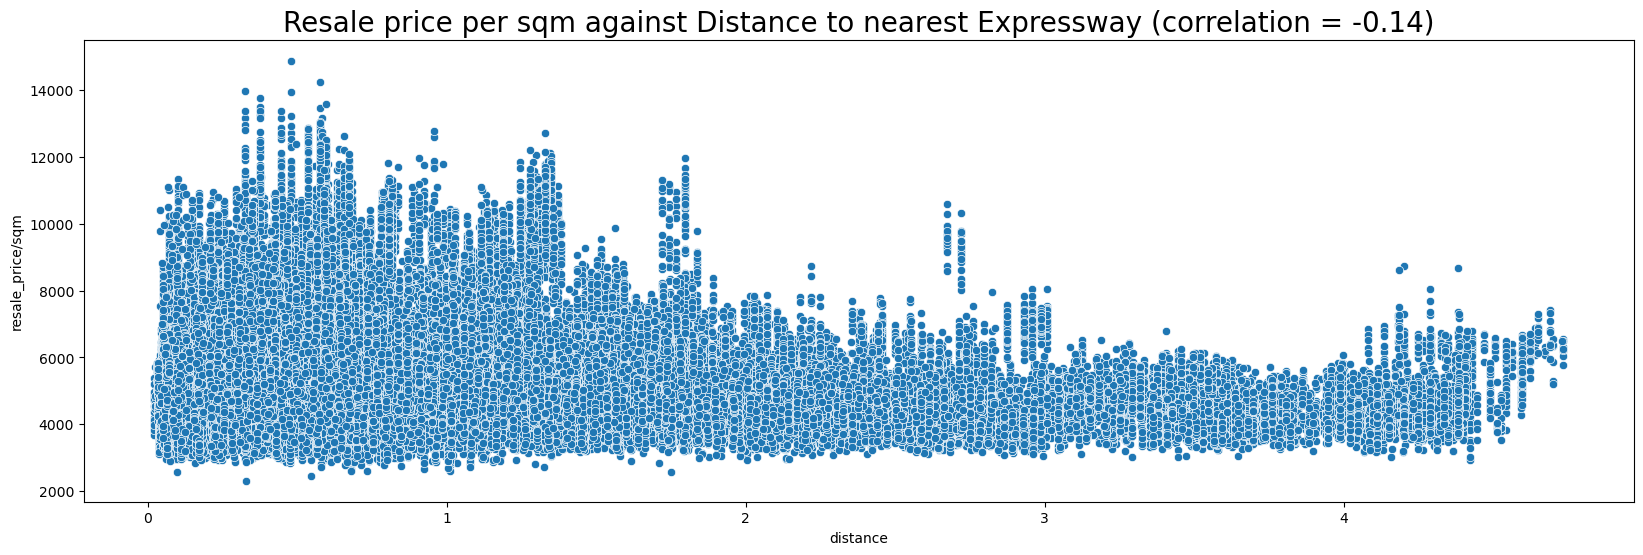

In [7]:
# Find correlation between distance and resale_price/sqm (corrected for inflation)
print(df['resale_price/sqm'].corr(df['distance']))
plt.figure(figsize=(20,6))
bar = sns.scatterplot(data = df, x = 'distance', y = 'resale_price/sqm')
plt.title('Resale price per sqm against Distance to nearest Expressway (correlation = -0.14)', fontsize = 20)

Which implies there isn't a strong correlation between resale_price/sqm and distance - hence this could support both arguments on whether expressway proximity is good or bad; but we need to dig for more granularity!

<i>An observation here is that property 3-4km away or further don't reach as high prices, but that's likely an effect of being in the heartlands, whereas central areas tends to be closer to some expressway or another - and central location is known to be a big factor for property prices in SG

Text(0.5, 1.0, 'Distribution of HDB flat resales by Distance from Expressways')

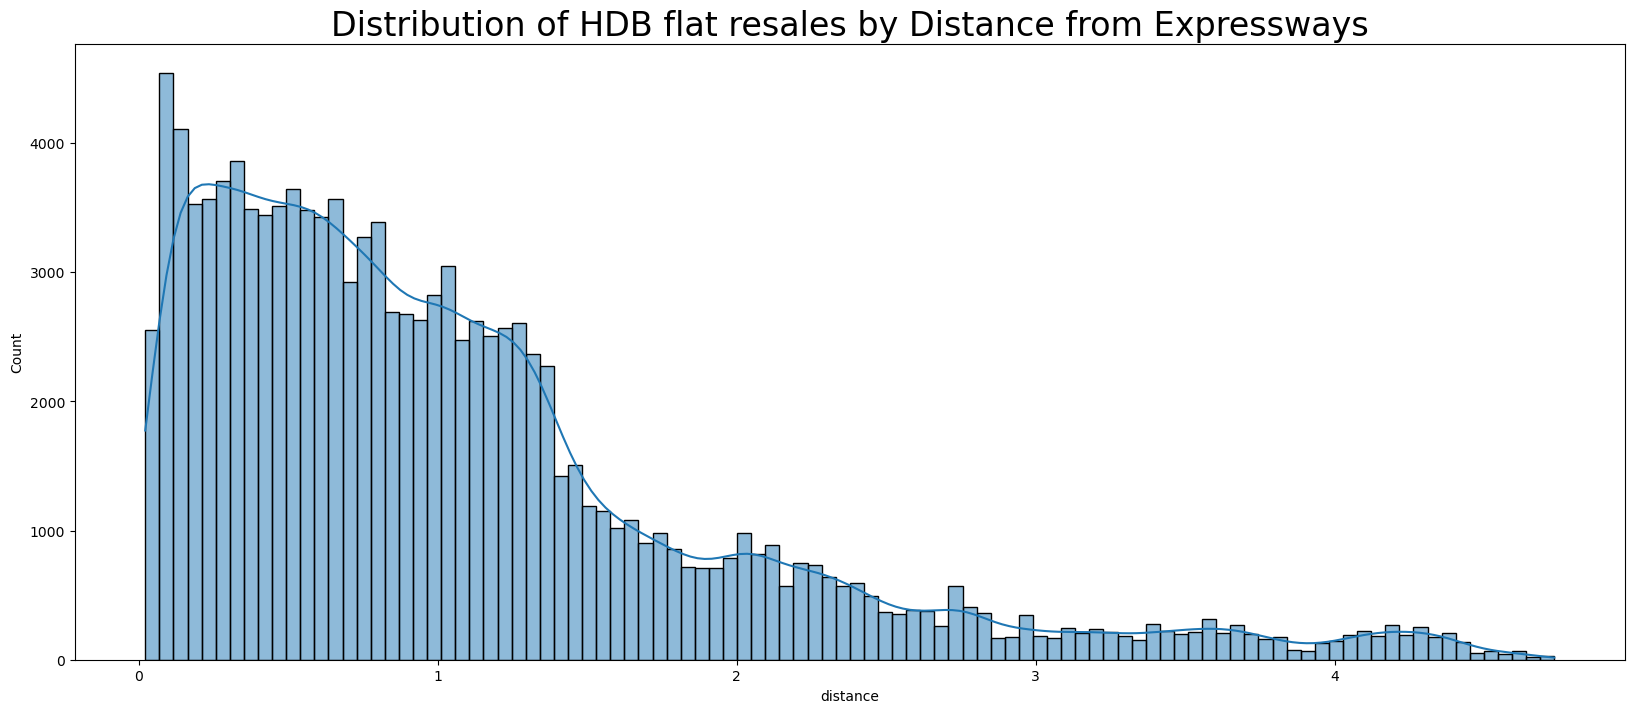

In [13]:
plt.figure(figsize=(20, 8))
sns.histplot(data=df, x='distance', bins=100, kde=True)
plt.title('Distribution of HDB flat resales by Distance from Expressways', fontsize = 24)

#### 3.1 Explore the different Expressways

In [14]:
# Get the list of unique expressways
expressways = df['nearest_line'].unique()

# Initialize an empty dictionary to store the correlations
expressway_correlations = {}

# Calculate the correlation for each expressway
for expressway in expressways:
    expressway_data = df[df['nearest_line'] == expressway]
    correlation = df['distance'].corr(expressway_data['resale_price/sqm'])
    expressway_correlations[expressway] = correlation

df_ex_corr = pd.DataFrame(expressway_correlations.items(), columns=['Expressway', 'Correlation']).sort_values('Correlation')

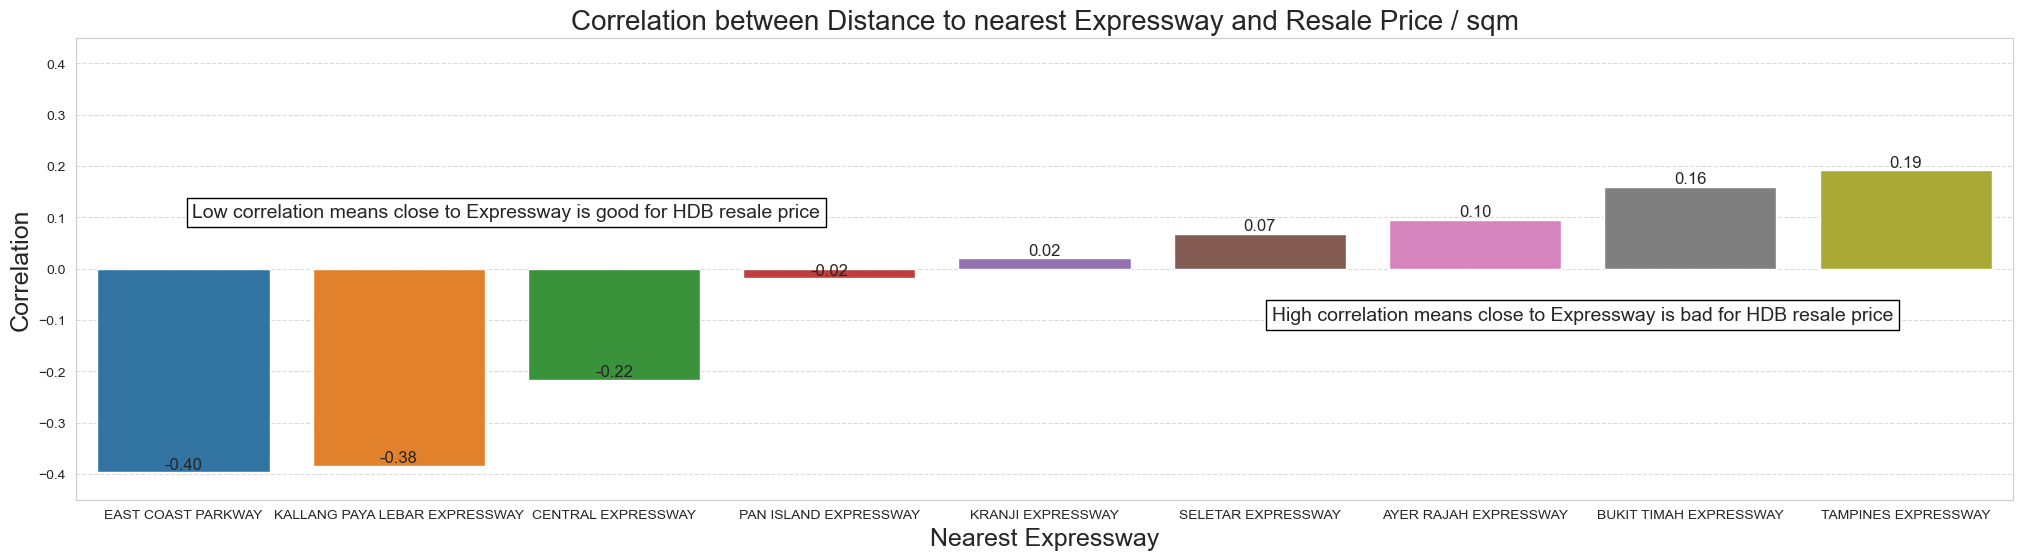

In [15]:
plt.figure(figsize=(25, 6))
sns.set_style("whitegrid")

bar = sns.barplot(data=df_ex_corr, x='Expressway', y='Correlation')

plt.xlabel("Nearest Expressway", fontsize=18)
plt.ylabel("Correlation", fontsize=18)
plt.title("Correlation between Distance to nearest Expressway and Resale Price / sqm", fontsize=20)
plt.ylim(-0.45, 0.45)

# Add text boxes
plt.text(1.5, 0.1, 'Low correlation means close to Expressway is good for HDB resale price', ha='center', fontsize=14,
         bbox=dict(facecolor='white', edgecolor='black'))
plt.text(6.5, -0.1, 'High correlation means close to Expressway is bad for HDB resale price', ha='center', fontsize=14,
         bbox=dict(facecolor='white', edgecolor='black'))

# Add labels with heights in the middle of the bars
for index, value in enumerate(df_ex_corr['Correlation']):
    plt.text(index, value, f"{value:.2f}", ha='center', va='bottom', fontsize=12)

# Enable grid
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.show()


-0.3956688121939429 0.1925368629489255


Text(0.5, 1.0, 'Tampines Expressway')

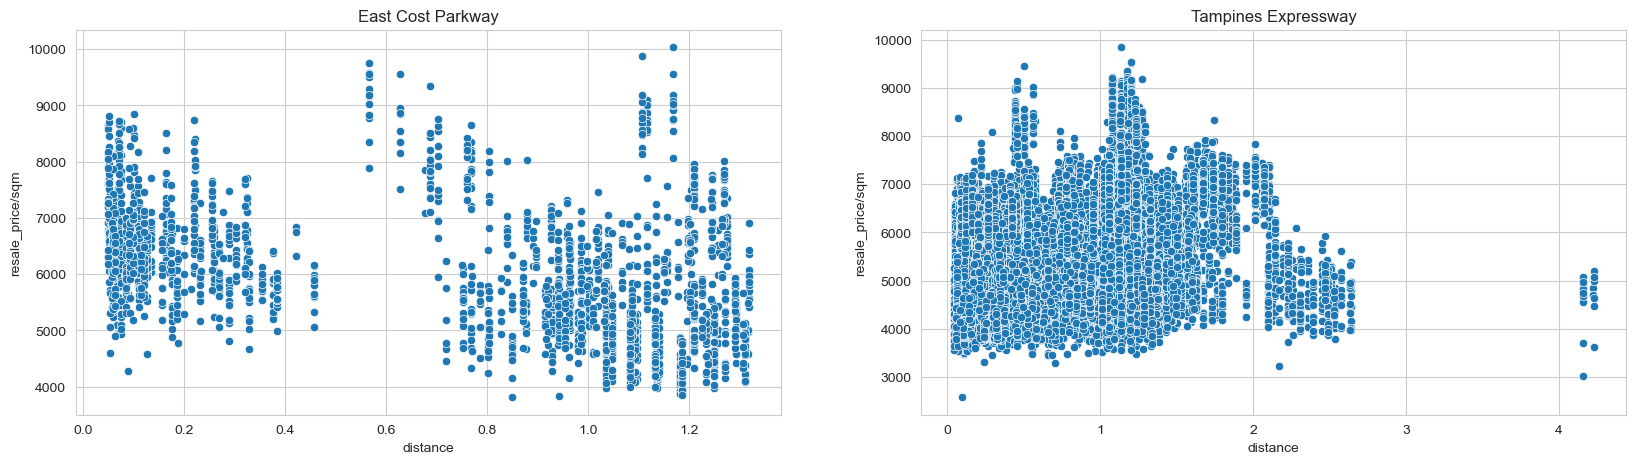

In [16]:
# Create a figure and two subplots side by side
df_ecp = df[df['nearest_line'] == 'EAST COAST PARKWAY']
df_tam = df[df['nearest_line'] == 'TAMPINES EXPRESSWAY']
print(df_ecp['resale_price/sqm'].corr(df_ecp['distance']), df_tam['resale_price/sqm'].corr(df_tam['distance']))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
sns.scatterplot(data = df_ecp, x = 'distance', y = 'resale_price/sqm',  ax=ax1)
ax1.set_title('East Cost Parkway')
sns.scatterplot(data = df_tam, x = 'distance', y = 'resale_price/sqm',  ax=ax2)
ax2.set_title('Tampines Expressway')

-0.38377890540765563 0.09571674467783792


Text(0.5, 1.0, 'AYER RAJAH Expressway')

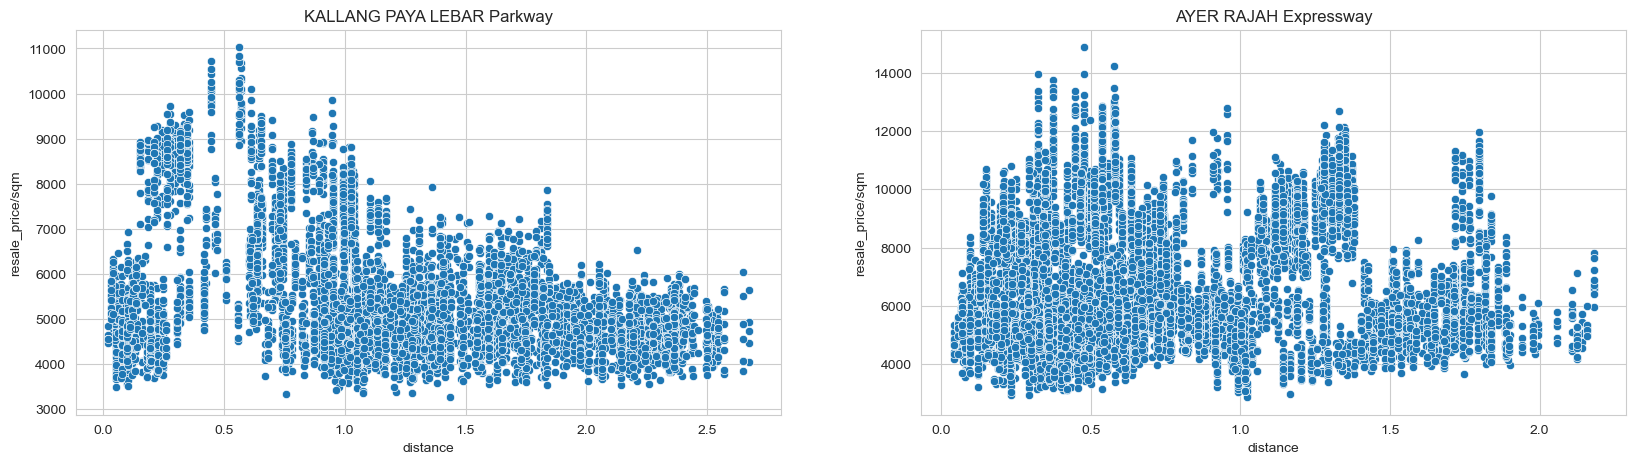

In [17]:
# Create a figure and two subplots side by side
df_ecp = df[df['nearest_line'] == 'KALLANG PAYA LEBAR EXPRESSWAY']
df_tam = df[df['nearest_line'] == 'AYER RAJAH EXPRESSWAY']
print(df_ecp['resale_price/sqm'].corr(df_ecp['distance']), df_tam['resale_price/sqm'].corr(df_tam['distance']))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
sns.scatterplot(data = df_ecp, x = 'distance', y = 'resale_price/sqm',  ax=ax1)
ax1.set_title('KALLANG PAYA LEBAR Parkway')
sns.scatterplot(data = df_tam, x = 'distance', y = 'resale_price/sqm',  ax=ax2)
ax2.set_title('AYER RAJAH Expressway')

<b>Trying a slightly different approach - segment the flats into those that are 'close' (<100m) to expressways, and those that are 'far' (>500m) from expressways - in the sense that 500m away, the effect of expressways is expected to be negligible</b>

In [47]:
# segment flats into 'close', 'medium', and 'far' from expressways.
df_close = df[df['distance'] < 0.1]
df_medium = df[(df['distance'] > 0.1) &(df['distance'] < 0.2) ]
df_far = df[df['distance'] > 0.5]

print(df_close['resale_price/sqm'].corr(df_close['distance']))

0.21211181973770993


In [ ]:
# get some stats for the close to expressway numbers
print('Number of unique transactions is', len(df_close))
print('Number of unique adddresses is', len(df_close.address.unique()))

In [ ]:
df_exp_close = df_close.groupby('nearest_line').median()
df_exp_far = df_far.groupby('nearest_line').median()
df_diff = (df_exp_far/df_exp_close).reset_index().sort_values('resale_price/sqm') 
df_diff['percentage_diff'] = df_diff['resale_price/sqm'] -1

plt.figure(figsize=(25, 6))
sns.set_style("whitegrid")
bar = sns.barplot(data=df_diff, x='nearest_line', y='percentage_diff')
# Add a dotted horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='dotted')

# Add labels with heights in the middle of the bars
for index, value in enumerate(df_diff['percentage_diff']):
    plt.text(index, value, f"{value:.2f}", ha='center', va='bottom', fontsize=12)

plt.title('Percentage difference for resale prices between Control group (i.e. far from Expressway) vs Target group (i.e. close from Expressway)', fontsize = 18)


#### 3.1 Explore high floor vs lower floors

In [7]:
# Just take the middle floor and convert to float
df['storey_range'] = pd.to_numeric(df['storey_range'].str[:2]) + 1

In [ ]:
print(df['storey_range'].corr(df['resale_price/sqm']))
plt.figure(figsize=(20, 6))
bar = sns.scatterplot(data = df, x = 'storey_range', y = 'resale_price/sqm')
plt.title('Resale Price against Floor Height, across all resale flats (corr = 0.51)', fontsize = 20)

Higher floors are naturally pricier, regardless of expressways 

Compare higher floors close to expressways (within 50m vs higher floors further away)

In [ ]:
print(df_close['storey_range'].corr(df_close['resale_price/sqm']))
plt.figure(figsize=(20, 6))
bar = sns.scatterplot(data = df_close, x = 'storey_range', y = 'resale_price/sqm')

In [ ]:
# Calculate the correlation for each expressway
def get_storey_price_corr(df):
    number_of_flats = []
    correlation = []
    express = []
    for expressway in expressways:
        expressway_data = df[df['nearest_line'] == expressway]
        
        correlation.append(expressway_data['storey_range'].corr(expressway_data['resale_price/sqm']))
        number_of_flats.append(len(expressway_data))
        express.append(expressway)
        
    df_expressway_corr = pd.DataFrame()
    df_expressway_corr['Expressway'] = express
    df_expressway_corr['Correlation'] = correlation
    df_expressway_corr['Flat_count'] = number_of_flats
    
    
    return df_expressway_corr.sort_values('Expressway')

In [ ]:
df_storey_price_corr = get_storey_price_corr(df)
df_storey_price_corr['Correlation_close'] = get_storey_price_corr(df_close)['Correlation']
df_storey_price_corr['Flat_count_close'] = get_storey_price_corr(df_close)['Flat_count']
df_storey_price_corr['Flat_count_close_%'] = round(get_storey_price_corr(df_close)['Flat_count'] * 100/ df_storey_price_corr['Flat_count'],1)
df_storey_price_corr['Correlation_far'] = get_storey_price_corr(df_far)['Correlation']
df_storey_price_corr['Flat_count_far'] = get_storey_price_corr(df_far)['Flat_count']
df_storey_price_corr.sort_values('Correlation_close',ascending = False)

#### As with before, we will segment the flats, but this time by 1) Low stories (below 5), and 2) High stories (above 12)

In [ ]:
df_short = df[df['storey_range'] < 6]
df_tall = df[df['storey_range'] > 12]

In [ ]:
df_tall['resale_price/sqm'].mean() / df_short['resale_price/sqm'].mean()

In general, high storey flats are 31.2% more expensive than low storey flats.

We want to check if this is more pronounced near expressways

In [ ]:
plt.figure(figsize=(20, 4))
sns.histplot(data=df, x='storey_range', bins=100, kde=True)
plt.title('Distribution of HDB flats by Number of Floors', fontsize = 16)
plt.xlabel('Storey')

In [ ]:
df_short_close = df[(df['storey_range'] < 6) & (df['distance'] < 0.1)]
df_tall_close = df[(df['storey_range'] > 12) & (df['distance'] < 0.1)]
df_tall_close['resale_price/sqm'].mean() / df_short_close['resale_price/sqm'].mean()

In [ ]:
df_short_far = df[(df['storey_range'] < 6) & (df['distance'] > 0.5)]
df_tall_far = df[(df['storey_range'] > 12) & (df['distance'] > 0.5)]
df_tall_far['resale_price/sqm'].mean() / df_short_far['resale_price/sqm'].mean()

#### Difference-in-difference (DID) model to see if the effect is really due to expressway, or something else

To complete if time permits (but also need to finish the DSAID AIPF assessment; so might not come back to this!)

#### Explainability of various factors - using SHAP

In [36]:
import shap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import catboost
from catboost import CatBoostRegressor, Pool

In [49]:
# correct the data types
df['storey_range'] = pd.to_numeric(df['storey_range'].str[:2]) + 1
df['remaining_lease'] = 99 - (df['resale_date'].dt.year - df['lease_commence_date'])

In [72]:
predictors = ['storey_range','remaining_lease']

X = df[predictors]
y= df['resale_price/sqm']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Train a decision tree regressor
model = DecisionTreeRegressor(max_depth=4)
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.40922069945303374

<Axes: title={'center': 'Resale Price /sqm by Town'}, xlabel='town'>

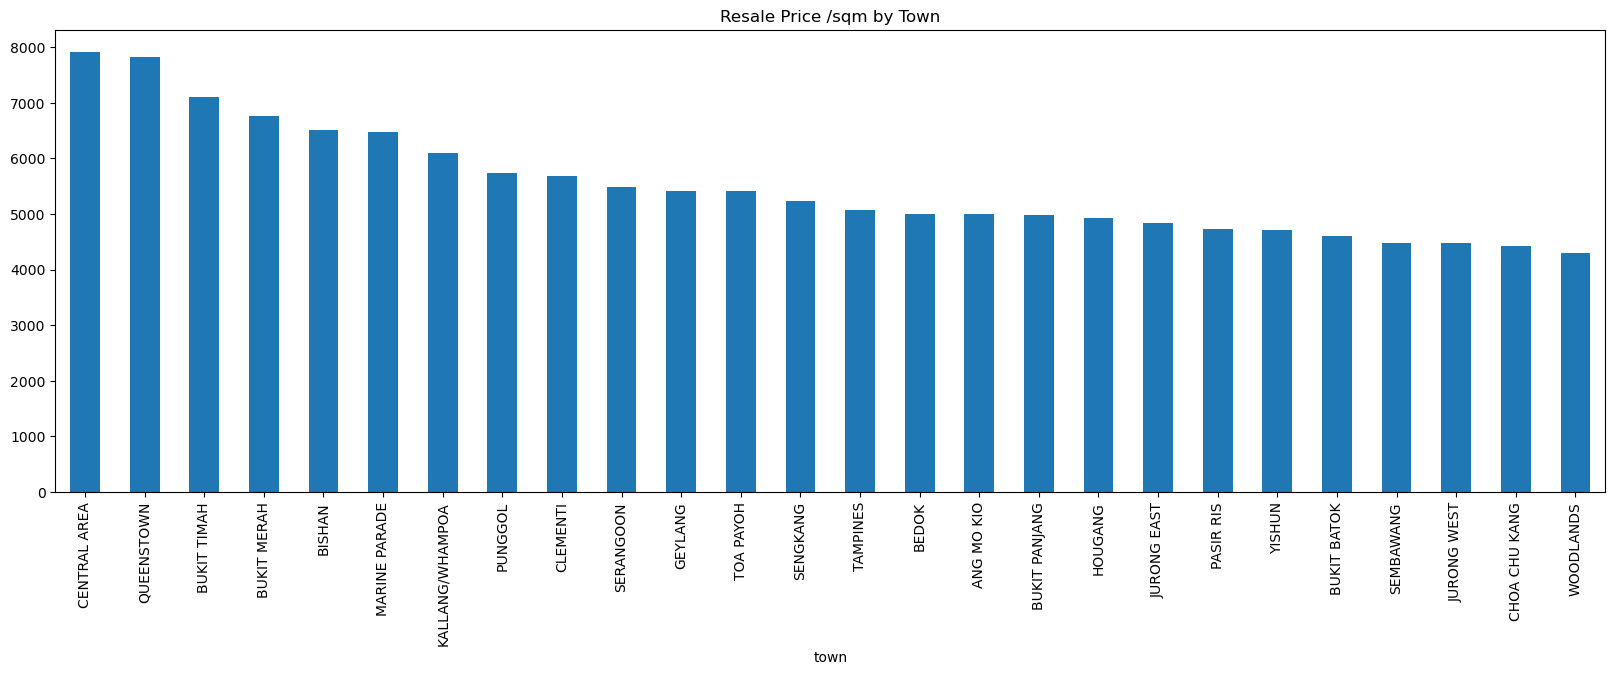

In [30]:
df.groupby('town').median(numeric_only = True)['resale_price/sqm'].sort_values(ascending = False).plot(kind = 'bar', figsize = (20,6), title = 'Resale Price /sqm by Town')

<Axes: title={'center': 'Median resale price over time'}, xlabel='resale_date'>

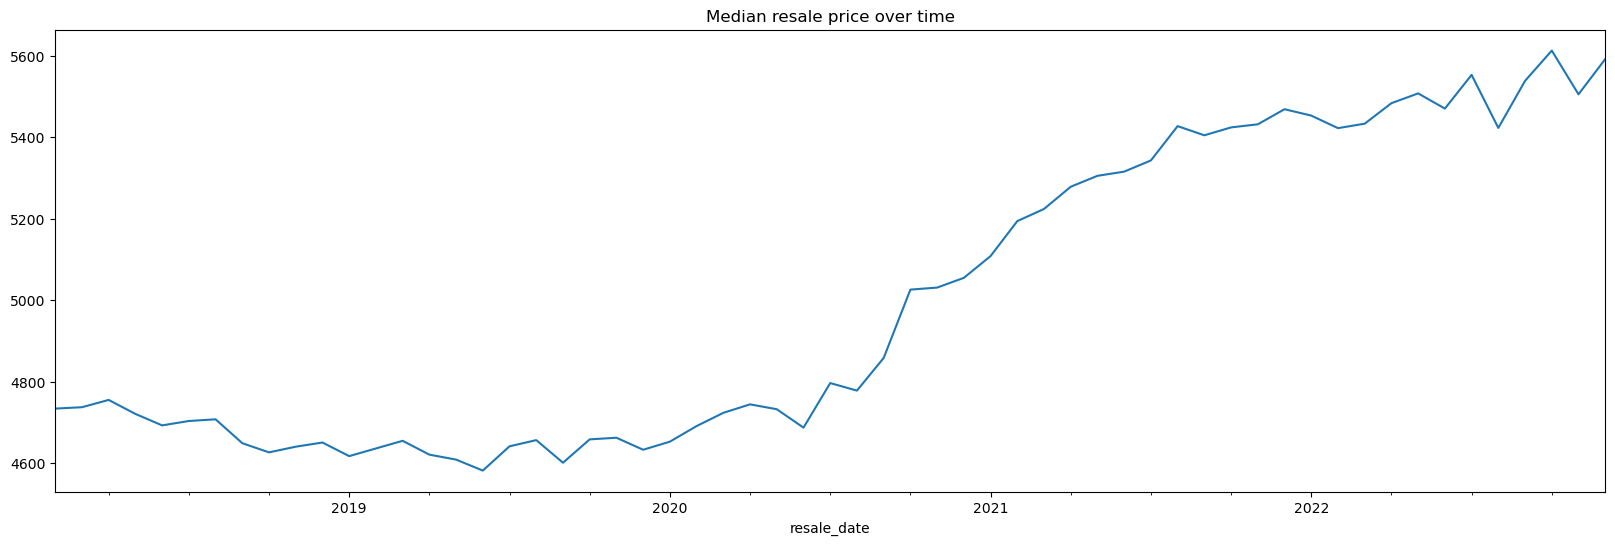

In [65]:
df.groupby('resale_date').median()['resale_price/sqm'].plot(figsize = (20,6), title = 'Median resale price over time')

In [95]:
pd.DataFrame(df.describe().iloc[1,:])

,mean
latitude,1.367827
longitude,103.842464
floor_area_sqm,97.642431
remaining_lease,74.795155
lease_commence_date,1995.950247
storey_range,8.769200
resale_price_with_inf,522265.891716
resale_price/sqm,5389.582787
distance,1.072392


In [83]:
predictors = ['storey_range','remaining_lease','floor_area_sqm','distance']

X = df[predictors]
y= df['resale_price_with_inf']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Train a decision tree regressor
model = DecisionTreeRegressor(max_depth=4)
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.5810819555640843

In [84]:
predictors = ['storey_range','remaining_lease','floor_area_sqm','distance','town']
X = df[predictors]
y= df['resale_price_with_inf']

cat_features = ['town']

model = CatBoostRegressor(iterations=500, learning_rate=0.1, depth=2, verbose=0)
model.fit(X, y, cat_features=cat_features)

In [86]:
model.score(X,y)

0.8759637014219859

In [38]:
pd.DataFrame(df.iloc[0,3:]).transpose()

,town,flat_type,flat_model,floor_area_sqm,remaining_lease,lease_commence_date,storey_range,resale_price_with_inf,resale_price/sqm,nearest_line,resale_date,distance
0,CHOA CHU KANG,4 ROOM,Model A,92.0,93.833333,2017,20,580000.0,6304.347826,KRANJI EXPRESSWAY,2022-12-01,1.22356


Misc - export the relevant datasets for visualizations on Tableau

In [8]:
# segmenting based on storey
df_short = df[df['storey_range'] < 6]
df_tall = df[df['storey_range'] > 12]

# segmenting based on distance
df_close = df[df['distance'] < 0.1]
df_medium = df[(df['distance'] > 0.1) &(df['distance'] < 0.2) ]
df_far = df[df['distance'] > 0.5]

# segmenting based on

In [10]:
df_close.to_csv("close_to_expressway.csv",index = False)

In [11]:
df_far.to_csv("far_from_expressway.csv", index = False)